In [1]:
import json
from itertools import product
from pathlib import Path
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from more_itertools import chunked, difference
from sklearn.cluster import KMeans

In [2]:
# Select a version from https://ddragon.leagueoflegends.com/api/versions.json
VERSION = '11.15.1'
PATCH = '11.15'

In [3]:
DATA_DIR = Path('./data') / VERSION

def cache(get_path):
    def _cache(func):
        def wrapper(*args, **kwargs):
            path = get_path(*args, **kwargs)
            if path.exists():
                with path.open(encoding='utf8') as f:
                    result = json.load(f)
            else:
                result = func(*args, **kwargs)
                if not path.parent.exists():
                    path.parent.mkdir(parents=True)
                with path.open(mode='w', encoding='utf8') as f:
                    json.dump(result, f)
            return result
        return wrapper
    return _cache

In [4]:
def get_champion_path(*args, **kwargs):
    return DATA_DIR / 'champions.json'

@cache(get_champion_path)
def get_champion_data():
    champion_url = f'https://ddragon.leagueoflegends.com/cdn/{VERSION}/data/en_US/champion.json'
    res = requests.get(champion_url)
    return res.json()

champion_data = get_champion_data()
champions = list(champion_data['data'].keys())

def get_champion_id(champion: str) -> str:
    return champion_data['data'][champion]['key']

In [5]:
def get_stats_path(*args, **kwargs):
    arg_s = '_'.join(args)
    return DATA_DIR / 'get_stats' / f'get_stats_{arg_s}.json'

@cache(get_stats_path)
def get_stats(champion: str) -> dict:
    champion_id = get_champion_id(champion)
    params = {
        'ep': 'champion',
        'p': 'd',
        'v': '9',
        'patch': PATCH,
        'cid': champion_id,
        'lane': 'default',
        'tier': 'platinum_plus',
        'queue': '420',
        'region': 'all',
    }
    # This API no longer exists.
    res = requests.get('https://apix1.op.lol/mega/', params=params)
    sleep(2) # Self throttle.
    return res.json()

In [6]:
def winrate_by_time(stats):
    winrates = []
    for i in '1234567':
        games = stats['time'][i]
        games_won = stats['timeWin'][i]
        winrates.append(games_won / games)
    return winrates

def mean(stats):
    return sum(stats['timeWin'].values()) / sum(stats['time'].values())

def normalize(xs, avg):
    return [x - avg for x in xs]

def shape(winrates):
    threshold = 0.005
    shapes = []
    for s in chunked(difference(winrates, initial=True), 1):
        dx = sum(s)
        if dx < -threshold:
            shape = '\\'
        elif dx > threshold:
            shape = '/'
        else:
            shape = '-'
        shapes.append(shape)
    return ''.join(shapes)

data = []
for champion in champions:
    stats = get_stats(champion)
    winrates = winrate_by_time(stats)
    signs = [x >= 0 for x in difference(winrates)]
    data.append({
        'name': champion,
        'winRate': winrates,
        'winRateNorm': normalize(winrates, mean(stats)),
        'range': max(winrates) - min(winrates),
        'signs': tuple(signs),
        'signCount': sum(signs),
        'sign': winrates[0] <= winrates[-1],
        'argmax': max([(x, i) for i, x in enumerate(winrates)])[1],
        'argmin': min([(x, i) for i, x in enumerate(winrates)])[1],
        'shape': shape(winrates),
    })

df = pd.DataFrame(data)

In [7]:
def get_features(row):
    d = list(difference(row['winRate'], initial=True))
    return d + row['winRateNorm']

win_rates = df.apply(get_features, axis=1)

kmeans = KMeans(n_clusters=20, random_state=0).fit(np.array(list(win_rates)))
df['label'] = kmeans.labels_

In [8]:
df

,name,winRate,winRateNorm,range,signs,signCount,sign,argmax,argmin,shape,label
0,Aatrox,"[0.5565042692114516, 0.5414971521562246, 0.521...","[0.04464091769621803, 0.02963380064099108, 0.0...",0.077863,"(True, False, False, False, False, False, False)",1,False,0,6,\\\\\\,8
1,Ahri,"[0.539622641509434, 0.5431313236674664, 0.5475...","[0.011141682435996447, 0.014650364594028908, 0...",0.047421,"(True, True, True, False, False, False, False)",3,False,2,6,--\\\-,3
2,Akali,"[0.4651567944250871, 0.4430042819118158, 0.453...","[-0.00891540168622984, -0.031067914199501168, ...",0.061868,"(True, False, True, True, True, True, False)",5,True,5,1,\////\,10
3,Akshan,"[0.5806794055201698, 0.5305378908320085, 0.480...","[0.10504569433732569, 0.054904179649164386, 0....",0.119085,"(True, False, False, False, False, True, True)",3,False,0,4,\\\-/-,4
4,Alistar,"[0.496735308890005, 0.4793699306453509, 0.4955...","[-0.0071610829533306775, -0.024526461197984795...",0.047807,"(True, False, True, True, True, False, True)",5,True,6,1,\///\/,10
...,...,...,...,...,...,...,...,...,...,...,...
151,Zed,"[0.5676691729323309, 0.5514457917772835, 0.507...","[0.056546533106275, 0.0403231519512276, -0.003...",0.068246,"(True, False, False, False, True, True, False)",3,False,0,3,\\\//-,14
152,Ziggs,"[0.5554826001313198, 0.5532647565228909, 0.575...","[0.020133865834811582, 0.017916022226382666, 0...",0.090042,"(True, False, True, False, False, False, True)",3,False,2,5,-/\\\/,18
153,Zilean,"[0.4686971235194585, 0.51359682924144, 0.54391...","[-0.0613326146678726, -0.01643290894589111, 0....",0.075218,"(True, True, True, False, True, False, False)",4,True,2,0,//\-\\,0
154,Zoe,"[0.5278622087132725, 0.5332210853516384, 0.501...","[0.03539828269111828, 0.04075715932948415, 0.0...",0.062953,"(True, True, False, False, False, True, True)",4,False,1,4,/\\\//,8


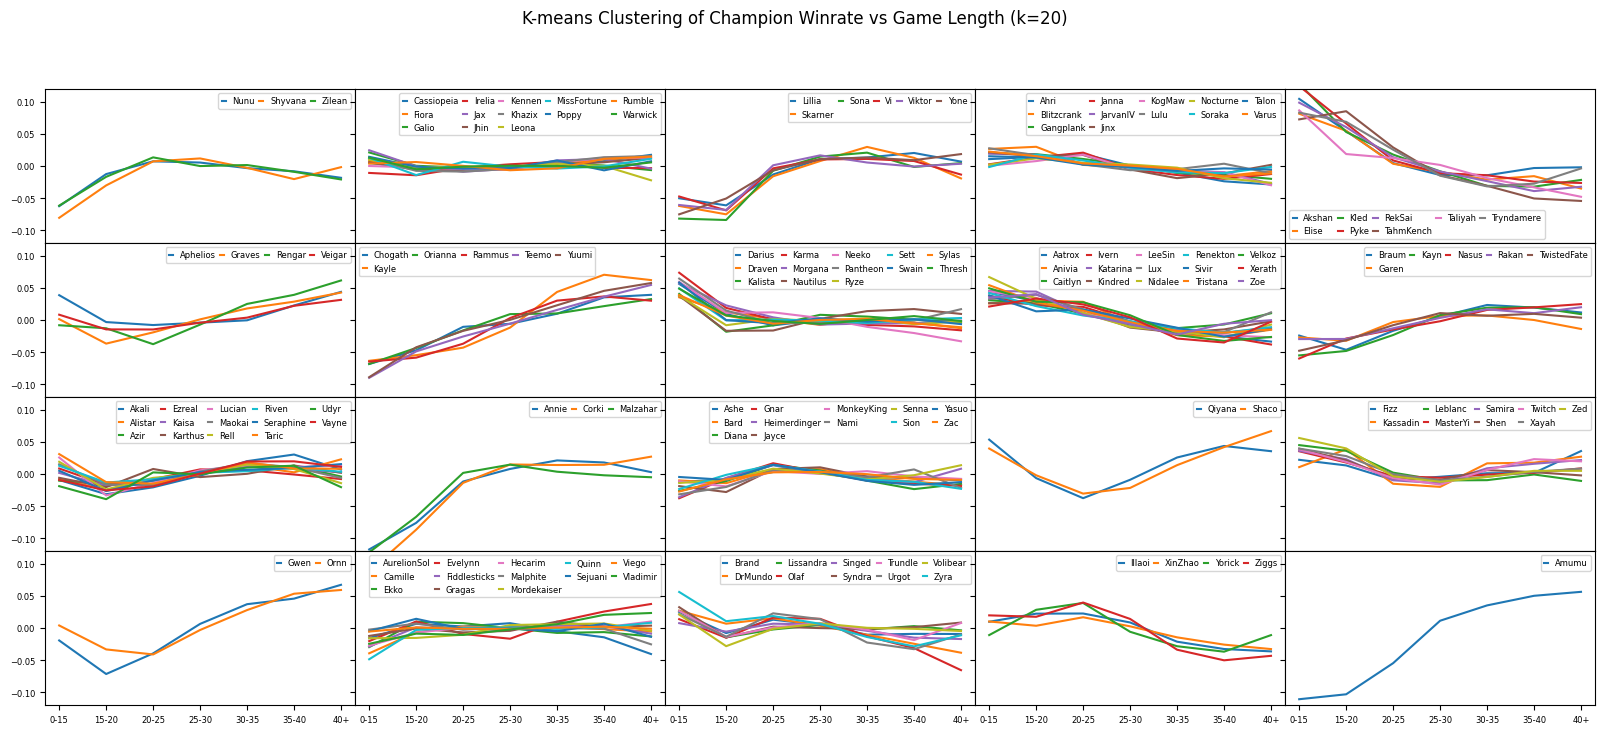

In [9]:
def plot(df):
    fig = plt.figure(figsize=(20, 8))
    fig.suptitle('K-means Clustering of Champion Winrate vs Game Length (k=20)')
    gs = fig.add_gridspec(4, 5, hspace=0, wspace=0)
    axs = gs.subplots(sharex='col', sharey='row')

    for i, j in product(range(4), range(5)):
        label = 5*i + j
        ax = axs[i, j]
        for _, c in df[df['label'] == label].iterrows():
            ax.plot([1,2,3,4,5,6,7], c['winRateNorm'], label=c['name'])
        ax.legend(
            ncol=5,
            handlelength=0.5,
            columnspacing=0.5,
            prop={'size': 6})
        ax.set_ylim(-0.12, 0.12)
        ax.set_xticks([1,2,3,4,5,6,7])
        ax.set_xticklabels(['0-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40+'])
        ax.tick_params(axis='both', which='major', labelsize=6)

    for ax in axs.flat:
        ax.label_outer()
    plt.show()

plot(df)